This file generates plots for fairness metrics in machine learning models trained with Stochastic Ghost. It provides a convenient tool for visualizing various fairness measures, such as disparate impact, equal opportunity, and predictive parity or anything specific according to the use case, to assess the performance and fairness of models across different demographic groups.

In [313]:
import os
from sklearn.metrics import roc_curve, auc, log_loss
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn, tensor
from torch.utils.data import TensorDataset
from torcheval.metrics.functional import binary_accuracy ,binary_auroc, binary_confusion_matrix
from src.experiments.utils.load_folktables import load_folktables_torch
from src.algos.constraints import *

In [314]:
t1 = torch.tensor(1.)
t2 = torch.tensor(5.)
x = torch.tensor(1., requires_grad=True)

# l = t2*x
# l.backward()
# x.grad

In [315]:
l1 = (t1*x)
l2 =-(t2*x) 
l = torch.concat([
    l1.unsqueeze(0),
    l2.unsqueeze(0)
])

l = torch.sum(torch.maximum(l, torch.zeros(2)))

l.backward()
x.grad

tensor(1.)

### **Preparation**

**Load the Folktables Employment dataset for the selected state and prepare it for usage**

In [316]:
TASK = 'income'
STATE = 'OK'

In [317]:
X_train, y_train, [w_idx_train, nw_idx_train], X_test, y_test, [w_idx_test, nw_idx_test] = load_folktables_torch(
        TASK, state=STATE, random_state=42, make_unbalanced = False, onehot=False
    )

sensitive_value_0 = 'white'
sensitive_value_1 = 'non-white'

In [318]:
device = 'cuda' if torch.cuda.is_available() and False else 'cpu'

In [319]:
X_train_tensor = tensor(X_train, dtype=torch.float, device=device)
y_train_tensor = tensor(y_train, dtype=torch.float, device=device)
    
X_test_tensor = tensor(X_test, dtype=torch.float, device=device)
y_test_tensor = tensor(y_test, dtype=torch.float, device=device)
    
X_train_w = X_train_tensor[w_idx_train]
y_train_w = y_train_tensor[w_idx_train]
X_train_nw = X_train_tensor[nw_idx_train]
y_train_nw = y_train_tensor[nw_idx_train]
    
X_test_w = X_test_tensor[w_idx_test]
y_test_w = y_test_tensor[w_idx_test]
X_test_nw = X_test_tensor[nw_idx_test]
y_test_nw = y_test_tensor[nw_idx_test]

In [320]:
loaded_models = []

**Load saved models**

In [321]:
LOSS_BOUND = 0.005
DATASET = TASK + '_' + STATE
DIRECTORY_PATH = "./src/experiments/utils/saved_models/" + DATASET + '/' + f'{LOSS_BOUND:.0e}' + '/'
FILE_EXT = '.pt'

In [322]:
class SimpleNet(nn.Module):
    def __init__(self, in_shape, out_shape):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_shape, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, out_shape),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [323]:

directory_path = DIRECTORY_PATH
file_list = os.listdir(directory_path)
model_files = [file for file in file_list if file.endswith(FILE_EXT)]
for model_file in model_files:
    model_name = model_file
    model = SimpleNet(X_test.shape[1], 1).to(device)
    try:
        model.load_state_dict(torch.load(directory_path + model_name, weights_only=False, map_location=device))
    except:
        continue
    print(model_file, end='\r')
    loaded_models.append((model_file, model))

**Train an unconstrained model with ADAM for comparison**

In [324]:
from src.algos.constraints import fairret_constr
from fairret.loss import NormLoss
from fairret.statistic import *


for _ in range(5):
    model_unconstr = SimpleNet(X_test.shape[1], 1).to(device)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model_unconstr.parameters(), lr=5e-3)

    train_ds = TensorDataset(X_train_tensor.to(device),y_train_tensor.to(device))
    train_l = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)

    history = {'c_train': [], 'c_test': [], 'tpr_0':[], 'tpr_1':[], 'fairret_val': []}

    c_f = fairret_constr
    statistic = PositiveRate()
    fpr_loss_train = NormLoss(statistic)
    fpr_loss_test = NormLoss(statistic)
    for _ in range(5):
        for i, (inputs, labels) in enumerate(train_l):
            model_unconstr.zero_grad()
            outputs = model_unconstr(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            # with torch.inference_mode():
            #     outs = model_unconstr(X_test_tensor)
            #     loss = loss_fn(outs, y_test_tensor).detach().cpu().numpy()
                
                
            #     c1_train = one_sided_loss_constr(loss_fn, model_unconstr, [(X_train_w, y_train_w), (X_train_nw, y_train_nw)]).detach().cpu().numpy()
            #     c2_train = -c1_train
            #     # fpr_test = fairret_constr(fpr_loss_test, model_unconstr, [(X_test_w, y_test_w), (X_test_nw, y_test_nw)]).detach().cpu().numpy()
            #     c1_test = one_sided_loss_constr(loss_fn, model_unconstr, [(X_test_w, y_test_w), (X_test_nw, y_test_nw)]).detach().cpu().numpy()
            #     c2_test = -c1_test
                
                
            #     # w_inputs, w_labels = X_T
            #     # b_inputs, b_labels = c_data[1]
            #     w_logits = model_unconstr(X_train_w)
            #     b_logits = model_unconstr(X_train_nw)
            #     w_onehot = torch.tensor([[0., 1.]]*len(X_train_w))
            #     b_onehot = torch.tensor([[1., 0.]]*len(X_train_nw))
            #     logits = torch.concat([w_logits, b_logits])
                
            #     sens = torch.vstack([w_onehot, b_onehot])
            #     labels = torch.vstack([y_train_w, y_train_nw])

            #     stat = TruePositiveRate()
            #     # print(logits.shape)
            #     # print(sens.shape)
            #     # print(labels.shape)
            #     tpr_0, tpr_1 = stat(torch.nn.functional.sigmoid(logits), sens, labels)
            #     history['tpr_0'].append(tpr_0)
            #     history['tpr_1'].append(tpr_1)
            #     fv = fairret_pr_constr(fpr_loss_train, model_unconstr, [(X_train_w, y_train_w), (X_train_nw, y_train_nw)]).detach().cpu().numpy()
            #     history['fairret_val'].append(fv)
            #     # history['fpr_test'].append(fpr_test)
            #     history['c_train'].append(c1_train)
            #     history['c_test'].append(c1_test)
            print(i, end='\r')
    loaded_models.append(('ADAM', model_unconstr))

In [325]:
# plt.plot(history['tpr_0'])
# plt.plot(history['tpr_1'])

In [326]:
# plt.plot(history['fairret_val'])

**Define some fairness metrics**

In [327]:
from fairret.statistic import *
# equal probability of positive outcome
# expect thresholded ({0, 1}) predictions
def stat_parity(p_1, p_2):
    ppo_1 = torch.sum(p_1 == 1)/len(p_1)
    ppo_2 = torch.sum(p_2 == 1)/len(p_2)
    return torch.abs(ppo_1 - ppo_2)

def pr_eq(p_1, y_1, p_2, y_2):
    fpr_0 = (p_1 @ (1-y_1)) / np.sum(1-y_1)
    fpr_1 = (p_2 @ (1-y_2)) / np.sum(1-y_2)
    return np.abs(fpr_0 - fpr_1)

# equal fnr
def conf_matrix(p_1, y_1, p_2, y_2):#
       
    p = torch.concat([torch.tensor(p_1), torch.tensor(p_2)]).unsqueeze(1)
    w_onehot = torch.tensor([[0., 1.]]*len(p_1))
    b_onehot = torch.tensor([[1., 0.]]*len(p_2))
    sens = torch.vstack([w_onehot,b_onehot])
    labels = torch.concat([torch.tensor(y_1), torch.tensor(y_2)]).unsqueeze(1)
    
    pr0, pr1 = PositiveRate()(p, sens)
    fpr0, fpr1 = FalsePositiveRate()(p, sens, labels)
    tpr0, tpr1 = TruePositiveRate()(p, sens, labels)
    tnr0, tnr1 = 1-fpr0, 1-fpr1
    fnr0, fnr1 = 1-tpr0, 1-tpr1
    acc0, acc1 = Accuracy()(p, sens, labels)
    # return fpr0, fpr1
    # fpr_0 = (p_1 @ (1-y_1)) / np.sum(1-y_1)
    # fpr_1 = (p_2 @ (1-y_2)) / np.sum(1-y_2)
    # tnr_0 = 1 - fpr_0
    # tnr_1 = 1 - fpr_1
    # tpr_0 = (p_1 @ y_1) / np.sum(y_1)
    # tpr_1 = (p_2 @ y_2) / np.sum(y_2)
    # fnr_0 = 1 - tpr_0
    # fnr_1 = 1 - tpr_1
    return acc0, acc1, pr0, pr1, fpr0, fpr1, tnr0, tnr1, tpr0, tpr1, fnr0, fnr1

# equal tpr and fpr
# def eq_odds(p_1, y_1, p_2, y_2):
#     tpr = 

### **Evaluation**

**Calculate test set statistics for the models - AUC, constraint satisfaction, loss, etc.**

In [328]:
import ot

@torch.inference_mode()
def make_model_stats_table(X_w, y_w, X_nw, y_nw):
    
    results_list = []
    loss_fn = torch.nn.BCEWithLogitsLoss()
    
    for model_index, model_iter in enumerate(loaded_models):
        (model_name, model) = model_iter

        if model_name.lower().startswith(('aug', 'al')):
            alg = 'AL'
        elif model_name.startswith('sg'):
            alg = 'SG'
        elif model_name.startswith('sslalm'):
            alg = 'SSPD'
        elif model_name.startswith('swsg'):
            alg = 'SWSG'
        else:
            alg = model_name
        predictions_0 = model(X_w)
        predictions_1 = model(X_nw)
        y_w = y_w.squeeze()
        y_nw = y_nw.squeeze()
        l_0 = loss_fn(predictions_0[:,0], y_w).cpu().numpy()
        l_1 = loss_fn(predictions_1[:,0], y_nw).cpu().numpy()
        predictions_0 = torch.nn.functional.sigmoid(predictions_0[:,0])
        predictions_1 = torch.nn.functional.sigmoid(predictions_1[:,0])
        acc_0 = binary_accuracy(predictions_0, y_w).cpu().numpy()
        acc_1 = binary_accuracy(predictions_1, y_nw).cpu().numpy()
        # Calculate AUCs for sensitive attribute 0
        fpr_0, tpr_0, thresholds_0 = roc_curve(y_w.cpu().numpy(), predictions_0.cpu().numpy())
        auc_0 = auc(fpr_0, tpr_0)
        # Calculate AUCs for sensitive attribute 1
        fpr_1, tpr_1, thresholds_1 = roc_curve(y_nw.cpu().numpy(), predictions_1.cpu().numpy())
        auc_1 = auc(fpr_1, tpr_1)
        auc_hm = (auc_0*auc_1)/(auc_0 + auc_1)
        auc_m = (auc_0+auc_1)/2
        # Calculate TPR-FPR difference for sensitive attribute 0
        tpr_minus_fpr_0 = tpr_0 - fpr_0
        optimal_threshold_index_0 = np.argmax(tpr_minus_fpr_0)
        optimal_threshold_0 = thresholds_0[optimal_threshold_index_0]

        # Calculate TPR-FPR difference for sensitive attribute 1
        tpr_minus_fpr_1 = tpr_1 - fpr_1
        optimal_threshold_index_1 = np.argmax(tpr_minus_fpr_1)
        optimal_threshold_1 = thresholds_1[optimal_threshold_index_1]
        
        sp = stat_parity(predictions_0 > 0.5, predictions_1 > 0.5)
        p_0_np = (predictions_0 > 0.5).cpu().numpy()
        p_1_np = (predictions_1 > 0.5).cpu().numpy()
        y_w_np = y_w.cpu().numpy()
        y_nw_np = y_nw.cpu().numpy()
        pe = pr_eq(p_0_np, y_w_np, p_1_np, y_nw_np)

        acc0, acc1, pr0, pr1, fpr_0, fpr_1, tnr_0, tnr_1, tpr_0, tpr_1, fnr_0, fnr_1 = conf_matrix(p_0_np, y_w_np, p_1_np, y_nw_np)

        a0, x0 = np.histogram(predictions_0, bins=50)
        a1, x1 = np.histogram(predictions_1, bins=x0)
        a0 = a0.astype(float)
        a1 = a1.astype(float)
        a0 /= np.sum(a0)
        a1 /= np.sum(a1)
        wd = ot.wasserstein_1d(x0[1:], x1[1:], a0, a1, p=2)

        # Store results in the DataFrame
        results_list.append({'Model': str(model_name),
                             'Algorithm': alg,
                                        # 'AUC_Sensitive_0': auc_0,
                                        # 'AUC_Sensitive_1': auc_1,
                                        # 'AUC_HM' : auc_hm,
                                        'AUC_M' : auc_m,
                                        # 'Balanced Accuracy 0': (tpr_0 + tnr_0) / 2,
                                        # 'Balanced Accuracy 1': (tpr_1 + tnr_1) / 2,
                                        'PR 0': pr0,
                                        'PR 1': pr1,
                                        'TPR 0': tpr_0,
                                        'TPR 1': tpr_1,
                                        'TPR diff (EqOp)': np.abs(tpr_0 - tpr_1),
                                        # 'FPR 0': fpr_0,
                                        # 'FPR 1': fpr_1,
                                        # 'TNR 0': tnr_0,
                                        # 'TNR 1': tnr_1,
                                        'Accuracy_0f': acc0,
                                        'Accuracy_1f': acc1,
                                        'Loss_0': l_0,
                                        'Loss_1': l_1,
                                        'SP': sp,
                                        'PE': pe,
                                        'WD': wd,
                                        # 'Optimal_Threshold_0': optimal_threshold_0,
                                        # 'Optimal_Threshold_1': optimal_threshold_1
                                        })
        
    res_df = pd.DataFrame(results_list)
    return res_df

**Aggregate statistics by algorithm:**

In [329]:
res_df= make_model_stats_table(X_test_w, y_test_w, X_test_nw, y_test_nw)
res_df['loss_abs_diff'] = abs(res_df.Loss_0 - res_df.Loss_1)
res_df.drop('Model', axis=1).groupby('Algorithm').mean()

,AUC_M,PR 0,PR 1,TPR 0,TPR 1,TPR diff (EqOp),Accuracy_0f,Accuracy_1f,Loss_0,Loss_1,SP,PE,WD,loss_abs_diff
Algorithm,,,,,,,,,,,,,,
ADAM,0.839422,0.165208,0.275431,0.432804,0.60268,0.169875,0.807002,0.787715,0.436035,0.406038,0.110223,0.034676,0.009998,0.029997
AL,0.835345,0.168053,0.267341,0.428571,0.575396,0.146824,0.802407,0.779026,0.443225,0.396994,0.099288,0.030419,0.008162,0.046231
SG,0.771293,0.277681,0.316105,0.513228,0.592205,0.078977,0.72779,0.740599,0.511176,0.516077,0.04055,0.022766,0.001783,0.012028
SSPD,0.780146,0.297374,0.36015,0.589418,0.670646,0.081228,0.739606,0.744794,0.521845,0.549619,0.062776,0.027169,0.004334,0.033406


In [330]:
res_df.drop('Model', axis=1).groupby('Algorithm').count()

,AUC_M,PR 0,PR 1,TPR 0,TPR 1,TPR diff (EqOp),Accuracy_0f,Accuracy_1f,Loss_0,Loss_1,SP,PE,WD,loss_abs_diff
Algorithm,,,,,,,,,,,,,,
ADAM,5,5,5,5,5,5,5,5,5,5,5,5,5,5
AL,5,5,5,5,5,5,5,5,5,5,5,5,5,5
SG,5,5,5,5,5,5,5,5,5,5,5,5,5,5
SSPD,5,5,5,5,5,5,5,5,5,5,5,5,5,5


**Optimal thresholds:**

In [331]:
results_list_nr = []

with torch.inference_mode():
    for model_index, model_iter in enumerate(loaded_models):
        # Set the model to evaluation mode
        (model_name, model) = model_iter
        model.eval()

        predictions_0 = model(X_test_w)
        predictions_1 = model(X_test_nw)

        # Calculate AUCs for sensitive attribute 0 
        fpr_0, tpr_0, thresholds_0 = roc_curve(y_test_w, predictions_0)
        auc_0 = auc(1-fpr_0, 1-tpr_0)  # AUC for FNR is calculated using TPR as x-axis and 1-FPR as y-axis
        tnr_minus_fnr_0 = (1-fpr_0) - (1-tpr_0)
        # Find the threshold that maximizes TPR - FPR difference
        optimal_threshold_index_0 = np.argmax(tnr_minus_fnr_0)
        optimal_threshold_0 = thresholds_0[optimal_threshold_index_0]

        # Calculate AUCs for sensitive attribute 1 
        fpr_1, tpr_1, thresholds_1 = roc_curve(y_test_nw, predictions_1)
        auc_1 = auc(1-fpr_1, 1-tpr_1)  # AUC for TNR is calculated using 1-FPR as x-axis and TPR as y-axis
        tnr_minus_fnr_1 = (1-fpr_1) - (1-tpr_1)
        # Find the threshold that maximizes TPR - FPR difference
        optimal_threshold_index_1 = np.argmax(tnr_minus_fnr_1)
        optimal_threshold_1 = thresholds_1[optimal_threshold_index_1]
        
        auc_hm = (auc_0*auc_1)/(auc_0+auc_1)
        results_list_nr.append({'Model': str(model_name),
                                            'AUC_Sensitive_0': auc_0,
                                            'AUC_Sensitive_1': auc_1,
                                            'Optimal_Threshold_0': optimal_threshold_0,
                                            'Optimal_Threshold_1': optimal_threshold_1,
                                            'AUC_HM': auc_hm
                                            })
        
    results_df_nr = pd.DataFrame(results_list_nr)

In [332]:
results_df_nr.sort_values(by='AUC_HM', ascending=False)

,Model,AUC_Sensitive_0,AUC_Sensitive_1,Optimal_Threshold_0,Optimal_Threshold_1,AUC_HM
8,sg_0.005_p0.3_trial3.pt,0.267388,0.331151,-0.146150,-0.654342,0.147936
12,sslalm_0.005_trial2.pt,0.222697,0.285021,-0.433013,-0.433267,0.125017
11,sslalm_0.005_trial1.pt,0.210356,0.274359,-0.252124,-0.894034,0.119066
9,sg_0.005_p0.3_trial4.pt,0.198132,0.246751,-0.565143,-0.794338,0.109892
7,sg_0.005_p0.3_trial2.pt,0.193836,0.233498,-0.554589,-0.907833,0.105913
14,sslalm_0.005_trial4.pt,0.182433,0.239044,-0.544839,-0.848048,0.103468
10,sslalm_0.005_trial0.pt,0.187738,0.226762,-0.106377,-0.389729,0.102706
5,sg_0.005_p0.3_trial0.pt,0.183056,0.226419,-0.515687,-1.087916,0.101221
6,sg_0.005_p0.3_trial1.pt,0.182980,0.223864,-0.436782,-0.869448,0.100684
13,sslalm_0.005_trial3.pt,0.172316,0.197818,-0.202717,-0.537642,0.092094


### **Model plots**

**We choose one model per algorithm to make some useful plots**

For now, choose the model with the highest mean AUC:

In [333]:
select_by = 'wd'

In [334]:
best_models = {}
algs = res_df.Algorithm.unique()
for alg in algs:
    alg_df = res_df[res_df.Algorithm == alg]
    if select_by == 'auc':
        model = loaded_models[alg_df.AUC_M.idxmax()]
    elif select_by == 'wd':
        model = loaded_models[alg_df.WD.idxmin()]
    best_models[alg] = model

In [335]:
from fairret.statistic import TruePositiveRate

statistic = Accuracy()

for alg in algs:
    model = best_models[alg][1]
    preds = torch.concat([model(X_test_w), model(X_test_nw)])
    pred = torch.sigmoid(preds)
    sens = torch.concat([torch.tensor([[1.,0.]]*len(X_test_w)), torch.tensor([[0.,1.]]*len(X_test_nw))])
    label = torch.concat([y_test_w, y_test_nw])

    stat_per_group = statistic(pred, sens, label.unsqueeze(1))
    absolute_diff = torch.abs(stat_per_group[0] - stat_per_group[1])
    print(alg)
    print(stat_per_group)
    print(absolute_diff)

AL
tensor([0.7058, 0.7507], grad_fn=<IndexPutBackward0>)
tensor(0.0449, grad_fn=<AbsBackward0>)
SG
tensor([0.5842, 0.5793], grad_fn=<IndexPutBackward0>)
tensor(0.0048, grad_fn=<AbsBackward0>)
SSPD
tensor([0.6106, 0.6084], grad_fn=<IndexPutBackward0>)
tensor(0.0022, grad_fn=<AbsBackward0>)
ADAM
tensor([0.7187, 0.7566], grad_fn=<IndexPutBackward0>)
tensor(0.0379, grad_fn=<AbsBackward0>)


#### Subgroup ROC

In [336]:
# from abroca import compute_abroca

# alg_dfs = []
# for alg in algs:
#     preds = np.concatenate([best_models[alg][1](X_test_w).detach().numpy(), best_models[alg][1](X_test_nw).detach().numpy()])
#     alg_dfs.append(pd.DataFrame({'preds': preds.T[0], 'label': np.concatenate([y_test_w, y_test_nw]), 'race': np.concatenate([[0]*len(X_test_w), [1]*len(X_test_nw)])}))

In [337]:
# slice = compute_abroca(alg_dfs[0], pred_col = 'preds' , label_col = 'label',         
#                        protected_attr_col = 'race', compare_type = 'binary', majority_protected_attr_val=0,
#                        n_grid = 10000, plot_slices = True)

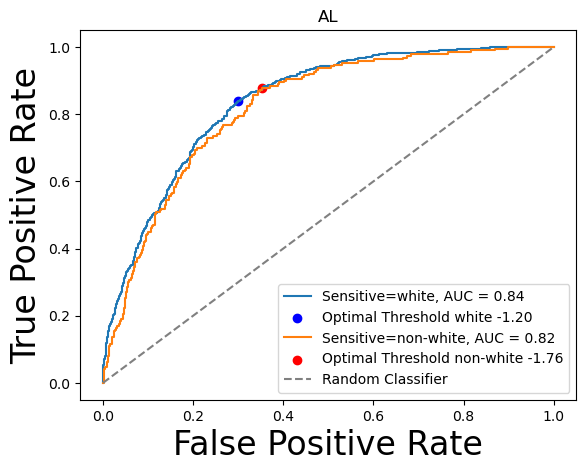

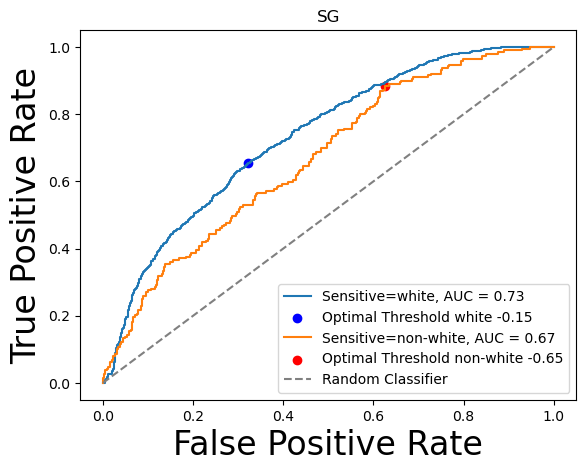

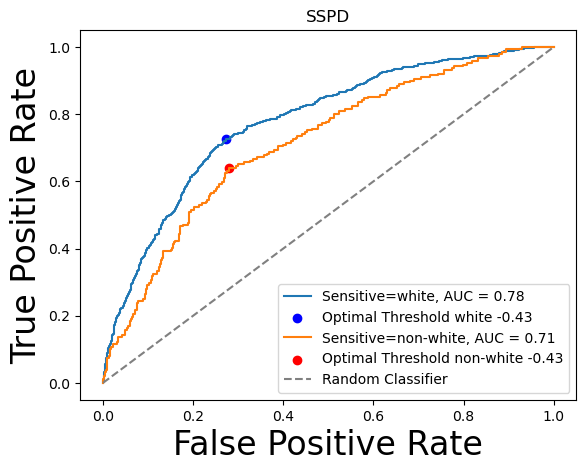

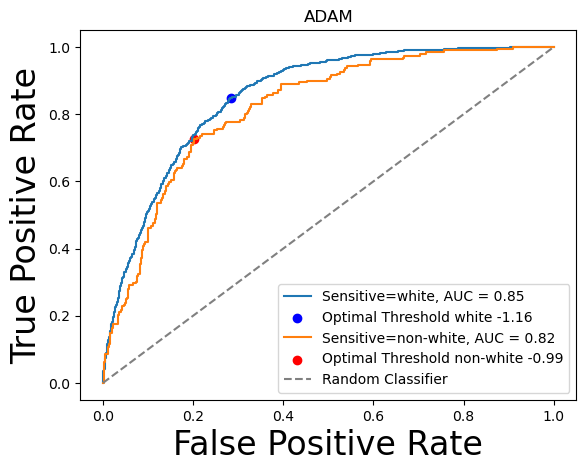

In [347]:
from sklearn.metrics import roc_curve, auc

# Function to generate predictions and plot ROC curve
def plot_roc_curve_pr(ax, predictions, targets, sensitive_value):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    ax.plot(fpr, tpr, label=f'Sensitive={sensitive_value}, AUC = {roc_auc:.2f}')
    tpr_minus_fpr = tpr - fpr
    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tpr_minus_fpr)
    optimal_threshold = thresholds[optimal_threshold_index]
    ax.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index],
                c='blue' if sensitive_value == sensitive_value_0 else 'red',
                label=f'Optimal Threshold {sensitive_value} {optimal_threshold:.2f}')
    
for alg, (model_name, model) in best_models.items():
    f = plt.figure()
    ax  =  f.subplots()
    ax.set_title(alg)
    with torch.inference_mode():
        predictions_0 = model(X_test_w)
        predictions_1 = model(X_test_nw)
        # Plot ROC for sensitive attribute A=0
        plot_roc_curve_pr(ax, predictions_0, y_test_w, sensitive_value=sensitive_value_0)
        # Plot ROC for sensitive attribute A=1
        plot_roc_curve_pr(ax, predictions_1, y_test_nw, sensitive_value=sensitive_value_1)
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
        ax.set_xlabel('False Positive Rate', fontsize=24)
        ax.set_ylabel('True Positive Rate', fontsize=24)
        ax.legend()

**TNR-FNR plot**

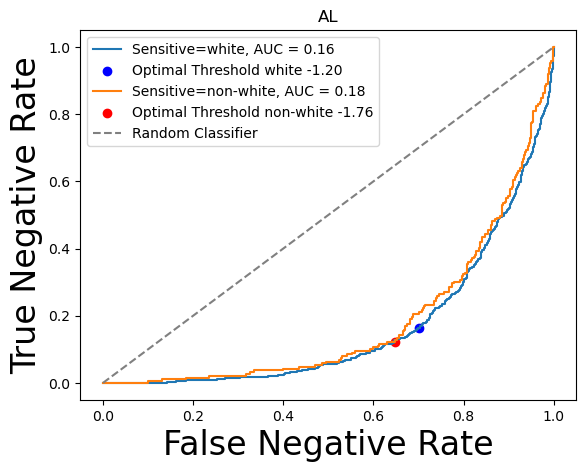

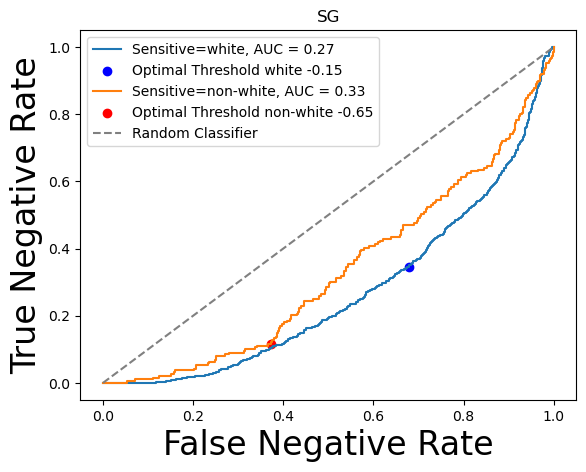

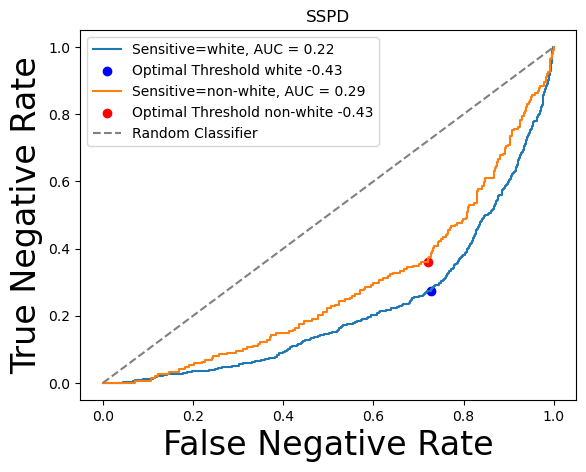

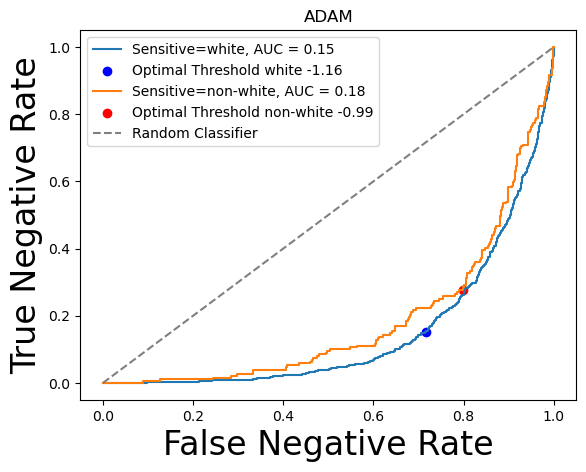

In [348]:
from sklearn.metrics import roc_curve, auc

# Function to generate predictions and plot ROC curve
def plot_roc_curve_nr(ax, predictions, targets, sensitive_value):
    # Convert PyTorch tensors to numpy arrays
    #predictions = predictions.detach().numpy()
    #targets = targets.numpy()

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    fnr = (1-tpr)
    tnr = (1-fpr)
    roc_auc = auc(tnr, fnr)
    # Plot ROC curve
    ax.plot(tnr, fnr, label=f'Sensitive={sensitive_value}, AUC = {roc_auc:.2f}')

    tnr_minus_fnr = tnr - fnr

    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tnr_minus_fnr)
    optimal_threshold = thresholds[optimal_threshold_index]
    ax.scatter(tnr[optimal_threshold_index],fnr[optimal_threshold_index],
                c='blue' if sensitive_value == sensitive_value_0 else 'red',
                label=f'Optimal Threshold {sensitive_value} {optimal_threshold:.2f}')
    
for alg, (model_name, model) in best_models.items():
    f = plt.figure()
    ax  =  f.subplots()
    ax.set_title(alg)
    with torch.inference_mode():
        predictions_0 = model(X_test_w)
        predictions_1 = model(X_test_nw)
        # Plot ROC for sensitive attribute A=0
        plot_roc_curve_nr(ax, predictions_0, y_test_w, sensitive_value=sensitive_value_0)
        # Plot ROC for sensitive attribute A=1
        plot_roc_curve_nr(ax, predictions_1, y_test_nw, sensitive_value=sensitive_value_1)
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
        ax.set_xlabel('False Negative Rate', fontsize=24)
        ax.set_ylabel('True Negative Rate', fontsize=24)
        ax.legend()

**Distribution of predictions by group:**

In [349]:
(model_name, model) = best_models['AL']

In [350]:
pr0 = torch.nn.functional.sigmoid(model(X_test_w)).detach().numpy()
pr1 = torch.nn.functional.sigmoid(model(X_test_nw)).detach().numpy()

a0, x0 = np.histogram(pr0, bins=50)
a1, x1 = np.histogram(pr1, bins=x0)
a0 = a0.astype(float)
a1 = a1.astype(float)
a0 /= np.sum(a0)
a1 /= np.sum(a1)

In [351]:
import ot
ot.wasserstein_1d(x0[1:], x1[1:], a0, a1, p=2)

0.0062301158599781005

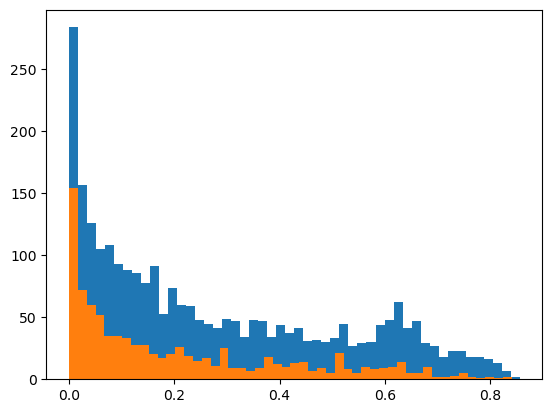

In [352]:
_, _ ,_ = plt.hist(pr0, bins=50)
_, _, _ =plt.hist(pr1, bins=50)

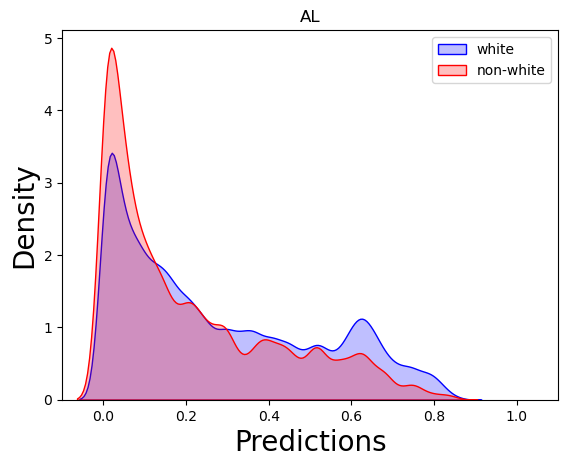

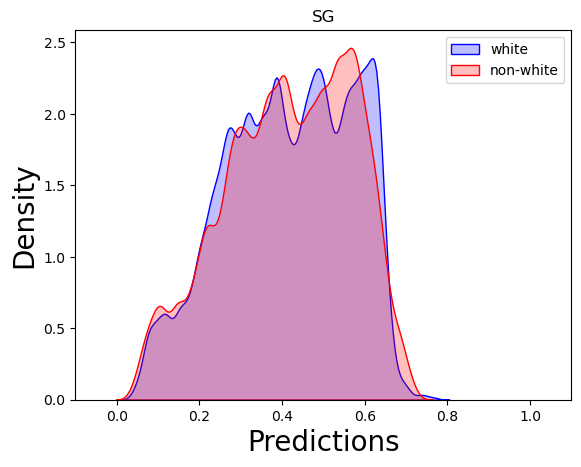

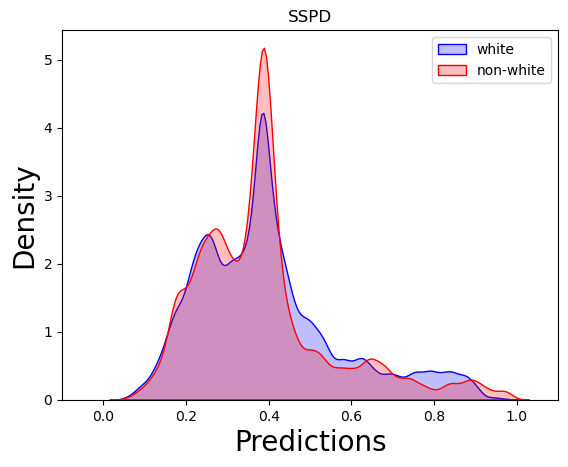

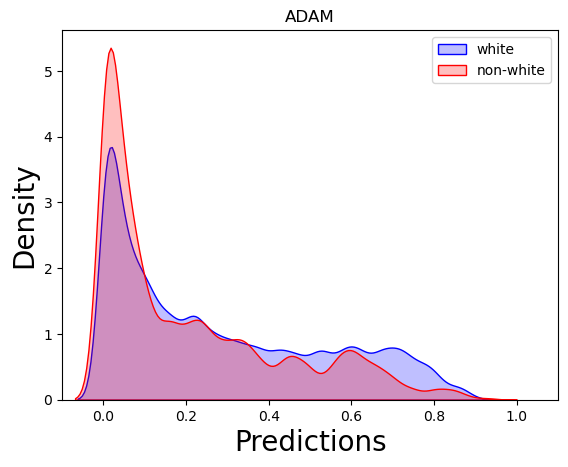

In [353]:
import seaborn as sns
import matplotlib.pyplot as plt

for alg, (model_name, model) in best_models.items():

    predictions_0 = torch.nn.functional.sigmoid(model(X_test_w)).detach().numpy()
    predictions_1 = torch.nn.functional.sigmoid(model(X_test_nw)).detach().numpy()
    
    sns.kdeplot(predictions_0.squeeze(), label=sensitive_value_0, color='blue', fill=True,bw_adjust=.4)
    sns.kdeplot(predictions_1.squeeze(), label=sensitive_value_1, color='red', fill=True,bw_adjust=.4)
    plt.xlim(-0.1, 1.1)
    plt.xlabel('Predictions', fontsize=20)
    plt.ylabel('Density', fontsize=20)
    plt.title(alg)
    plt.legend()
    plt.show()

In [354]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import pandas as pd

# Define function to calculate metrics based on threshold
def calculate_metrics(threshold):
    #acc_values = []

    # Calculate predictions for both sensitive values
    predictions_0_tensor = model(X_test_w)
    predictions_1_tensor = model(X_test_nw)
    
    # Convert predictions tensors to numpy arrays
    predictions_0 = predictions_0_tensor
    predictions_1 = predictions_1_tensor
    
    
    outputs = model.evaluate(model.to_backend(x_scaled))
    predictions = (outputs >= threshold)

    true = y

    df_out = pd.DataFrame(np.array(x_raw), columns=out_columns)
    df_out["pred_labels"] = np.array(predictions).astype(int)
    df_out["true_labels"] = np.array(true).astype(int)

    acc = len(df_out[df_out["true_labels"] == df_out["pred_labels"]]) / len(df_out)
    #acc_values.append(acc)

    # True Positives, False Positives, True Negatives, False Negatives
    # True Positives, False Positives, True Negatives, False Negatives
    tp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
    fp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
    tn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
    fn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])

    tp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
    fp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
    tn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
    fn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])

    # Additional calculations
    fpr_sensitive_1 = fp_sensitive_1 / (fp_sensitive_1 + tn_sensitive_1) 
    tpr_sensitive_1 = tp_sensitive_1 / (tp_sensitive_1 + fn_sensitive_1) 
    fpr_sensitive_0 = fp_sensitive_0 / (fp_sensitive_0 + tn_sensitive_0) 
    tpr_sensitive_0 = tp_sensitive_0 / (tp_sensitive_0 + fn_sensitive_0) 

    fnr_sensitive_1 = fn_sensitive_1 / (fn_sensitive_1 + tp_sensitive_1) 
    tnr_sensitive_1 = tn_sensitive_1 / (tn_sensitive_1 + fp_sensitive_1)
    fnr_sensitive_0 = fn_sensitive_0 / (fn_sensitive_0 + tp_sensitive_0) 
    tnr_sensitive_0 = tn_sensitive_0 / (tn_sensitive_0 + fp_sensitive_0)

    ppr_sensitive_0 = (tp_sensitive_0 + fp_sensitive_0) / len(df_out)
    ppr_sensitive_1 = (tp_sensitive_1 + fp_sensitive_1) / len(df_out)

    neg_precision_sensitive_0 = tn_sensitive_0/(tn_sensitive_0 + fn_sensitive_0)
    neg_precision_sensitive_1 = tn_sensitive_1/(tn_sensitive_1 + fn_sensitive_1)
    precision_sensitive_0 = tp_sensitive_0/(tp_sensitive_0 + fp_sensitive_0)
    precision_sensitive_1 = tp_sensitive_1/(tp_sensitive_1 + fp_sensitive_1)

    return {
        'tpr_'+str(sensitive_value_1): tpr_sensitive_1,
        'fpr_'+str(sensitive_value_1): fpr_sensitive_1,
        'tpr_'+str(sensitive_value_0): tpr_sensitive_0,
        'fpr_'+str(sensitive_value_0): fpr_sensitive_0,
        'fnr_'+str(sensitive_value_1): fnr_sensitive_1,
        'tnr_'+str(sensitive_value_1): tnr_sensitive_1,
        'fnr_'+str(sensitive_value_0): fnr_sensitive_0,
        'tnr_'+str(sensitive_value_0): tnr_sensitive_0,
        'ppr_'+str(sensitive_value_0): ppr_sensitive_0,
        'ppr_'+str(sensitive_value_1): ppr_sensitive_1,
        'neg_precision_'+str(sensitive_value_0): neg_precision_sensitive_0,
        'neg_precision_'+str(sensitive_value_1): neg_precision_sensitive_1,
        'precision_'+str(sensitive_value_0): precision_sensitive_0,
        'precision_'+str(sensitive_value_1): precision_sensitive_1,
        'acc': acc
    }

# Define function to calculate predictions and update plot based on threshold
def calculate_predictions(threshold):
    # Calculate predictions for both sensitive values
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    predictions_0_tensor = model(X_test_w)
    predictions_1_tensor = model(X_test_nw)
    
    # Convert predictions tensors to numpy arrays
    predictions_0 = predictions_0_tensor
    predictions_1 = predictions_1_tensor
    
    # Create density distribution plot
    sns.kdeplot(predictions_0.squeeze(), label=sensitive_value_0, color='blue', fill=True, ax = ax[0])
    sns.kdeplot(predictions_1.squeeze(), label=sensitive_value_1, color='red', fill=True, ax = ax[0])

    # Add labels and title
    ax[0].set_xlabel('Predictions')
    ax[0].set_ylabel('Density')
    ax[0].set_title('Density Distribution conditioned on Sensitive attribute')
    ax[0].axvline(x=threshold, color='green', linestyle='--', label='Threshold')
    ax[0].legend()

    metrics = calculate_metrics(threshold)

    categories2 = ['TPR', 'FPR', 'TNR', 'FNR']
    values3 = [metrics['tpr_'+str(sensitive_value_0)], metrics['fpr_'+str(sensitive_value_0)], 
               metrics['tnr_'+str(sensitive_value_0)], metrics['fnr_'+str(sensitive_value_0)]]
    values4 = [metrics['tpr_'+str(sensitive_value_1)], metrics['fpr_'+str(sensitive_value_1)], 
               metrics['tnr_'+str(sensitive_value_1)], metrics['fnr_'+str(sensitive_value_1)]]
    bar_width = 0.3
    index = np.arange(len(categories2))

    ax[1].bar(index, values3, color='blue', width=bar_width, label='S='+str(sensitive_value_0), alpha=0.5)
    ax[1].bar(index + bar_width, values4, color='red', width=bar_width, label='S='+str(sensitive_value_1), alpha=0.5)
    ax[1].set_xticks(index + bar_width / 2)
    ax[1].set_xticklabels(categories2)
    ax[1].set_ylabel("Fraction")
    ax[1].legend()
    ax[1].set_title("Performance metrics over dataset")

    # Show legend
    

    # Show plot
    plt.show()

    # Calculate and display metrics
    
    f1_sens_0 = 2*(metrics['tpr_'+str(sensitive_value_0)]*metrics['precision_'+str(sensitive_value_0)])/(metrics['tpr_'+str(sensitive_value_0)] + metrics['precision_'+str(sensitive_value_0)])
    f1_sens_1 = 2*(metrics['tpr_'+str(sensitive_value_1)]*metrics['precision_'+str(sensitive_value_1)])/(metrics['tpr_'+str(sensitive_value_1)] + metrics['precision_'+str(sensitive_value_1)])
    
    # Calculate and display metrics
    
    print("Accuracy:",metrics['acc'])
    print("precision "+str(sensitive_value_0)+":", metrics['precision_'+str(sensitive_value_0)], "   precision "+str(sensitive_value_1)+":", metrics['precision_'+str(sensitive_value_1)])
    print("recall "+str(sensitive_value_0)+":", metrics['tpr_'+str(sensitive_value_0)], "   recall "+str(sensitive_value_1)+":", metrics['tpr_'+str(sensitive_value_1)])
    print("FPR "+str(sensitive_value_0)+":", metrics['fpr_'+str(sensitive_value_0)], "   FPR "+str(sensitive_value_1)+":", metrics['fpr_'+str(sensitive_value_1)])
    print("F1 "+str(sensitive_value_0)+":", f1_sens_0, "   F1 "+str(sensitive_value_1)+":", f1_sens_1)




The decision threshold range can be usually determined from the ROC curves by analysing the optimal threshold values for sensitive attributes and swiping in a window containing the values. 

In [355]:
#select min and max values to view the metrics

######INCOME#######
#min_thresh = 0.446
#max_thresh = 0.460
######INCOME#######

######COMPAS#######
min_thresh = 0.461
max_thresh = 0.467
######COMPAS#######

steps = int((max_thresh - min_thresh)/50.)
# Create slider for selecting the shift value
shift_slider = FloatSlider(value=min_thresh, min=min_thresh, max=max_thresh, step=steps, description='Decision boundary:', readout_format='.4f')
# Create button for generating the plot
generate_button = Button(description='Generate')

# Output widget to display the plot
output = Output()

# Function to handle button click event
def on_button_click(button):
    with output:
        output.clear_output()
        calculate_predictions(shift_slider.value)

# Registering the button click event
generate_button.on_click(on_button_click)

# Arrange widgets
vbox = VBox([shift_slider, generate_button, output])
vbox

NameError: name 'FloatSlider' is not defined

Display various metrics for different threshold values in a range

In [ ]:
thresholds = np.linspace(min_thresh, max_thresh, 20)
acc_values = []
fpr_sensitive_1_values = []
tpr_sensitive_1_values = []
fpr_sensitive_0_values = []
tpr_sensitive_0_values = []
fnr_sensitive_1_values = []
tnr_sensitive_1_values = []
fnr_sensitive_0_values = []
tnr_sensitive_0_values = []
ppr_sensitive_0_values = []
ppr_sensitive_1_values = []
neg_precision_sensitive_0_values = []
neg_precision_sensitive_1_values = []
precision_sensitive_0_values = []
precision_sensitive_1_values = []

for thresh in thresholds:
    metrics = calculate_metrics(thresh)

    fpr_sensitive_1_values.append(metrics['fpr_'+str(sensitive_value_1)])
    tpr_sensitive_1_values.append(metrics['tpr_'+str(sensitive_value_1)])
    fpr_sensitive_0_values.append(metrics['fpr_'+str(sensitive_value_0)])
    tpr_sensitive_0_values.append(metrics['tpr_'+str(sensitive_value_0)])

    fnr_sensitive_1_values.append(metrics['fnr_'+str(sensitive_value_1)])
    tnr_sensitive_1_values.append(metrics['tnr_'+str(sensitive_value_1)])
    fnr_sensitive_0_values.append(metrics['fnr_'+str(sensitive_value_0)])
    tnr_sensitive_0_values.append(metrics['tnr_'+str(sensitive_value_0)])

    ppr_sensitive_0_values.append(metrics['ppr_'+str(sensitive_value_0)])
    ppr_sensitive_1_values.append(metrics['ppr_'+str(sensitive_value_1)])

    neg_precision_sensitive_1_values.append(metrics['neg_precision_'+str(sensitive_value_1)])
    neg_precision_sensitive_0_values.append(metrics['neg_precision_'+str(sensitive_value_0)])
    precision_sensitive_1_values.append(metrics['precision_'+str(sensitive_value_1)])
    precision_sensitive_0_values.append(metrics['precision_'+str(sensitive_value_0)])
    acc_values.append(metrics['acc'])



In [ ]:
data = {
    'thresh' : thresholds,
    'acc': acc_values, 
    'fpr_'+str(sensitive_value_1): fpr_sensitive_1_values,
    'tpr_'+str(sensitive_value_1): tpr_sensitive_1_values,
    'fpr_'+str(sensitive_value_0): fpr_sensitive_0_values,
    'tpr_'+str(sensitive_value_0): tpr_sensitive_0_values,
    'fnr_'+str(sensitive_value_1): fnr_sensitive_1_values,
    'tnr_'+str(sensitive_value_1): tnr_sensitive_1_values,
    'fnr_'+str(sensitive_value_0): fnr_sensitive_0_values,
    'tnr_'+str(sensitive_value_0): tnr_sensitive_0_values,
    'ppr_'+str(sensitive_value_0): ppr_sensitive_0_values,
    'ppr_'+str(sensitive_value_1): ppr_sensitive_1_values,
    'neg_precision_'+str(sensitive_value_0): neg_precision_sensitive_0_values,
    'neg_precision_'+str(sensitive_value_1): neg_precision_sensitive_1_values,
    'precision_'+str(sensitive_value_0): precision_sensitive_0_values,
    'precision_'+str(sensitive_value_1): precision_sensitive_1_values
}

# Create DataFrame
plot_df = pd.DataFrame(data)

In [ ]:
plot_df.sort_values(by='acc')

In [ ]:
plot_df['net_pres_'+str(sensitive_value_0)] = plot_df['neg_precision_'+str(sensitive_value_0)]*plot_df['precision_'+str(sensitive_value_0)]
plot_df['net_pres_'+str(sensitive_value_1)] = plot_df['neg_precision_'+str(sensitive_value_1)]*plot_df['precision_'+str(sensitive_value_1)]

In [ ]:
plot_df['F1_'+str(sensitive_value_0)] = 2*plot_df['precision_'+str(sensitive_value_0)]*plot_df['tpr_'+str(sensitive_value_0)]/(plot_df['precision_'+str(sensitive_value_0)] + plot_df['tpr_'+str(sensitive_value_0)])
plot_df['F1_'+str(sensitive_value_1)] = 2*plot_df['precision_'+str(sensitive_value_1)]*plot_df['tpr_'+str(sensitive_value_1)]/(plot_df['precision_'+str(sensitive_value_1)] + plot_df['tpr_'+str(sensitive_value_1)])

In [ ]:
plot_df['neg_F1_'+str(sensitive_value_0)] = plot_df['neg_precision_'+str(sensitive_value_0)]*plot_df['tnr_'+str(sensitive_value_0)]/(plot_df['neg_precision_'+str(sensitive_value_0)] + plot_df['tnr_'+str(sensitive_value_0)])
plot_df['neg_F1_'+str(sensitive_value_1)] = plot_df['neg_precision_'+str(sensitive_value_1)]*plot_df['tnr_'+str(sensitive_value_1)]/(plot_df['neg_precision_'+str(sensitive_value_1)] + plot_df['tnr_'+str(sensitive_value_1)])

In [ ]:
import matplotlib.pyplot as plt

# Your DataFrame plot_df
# Assuming plot_df contains columns: 'thresh', 'acc', 'net_pres_male', 'net_pres_female'

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 6))  # Increase the figure size

# Plotting accuracy on the left y-axis
color = 'green'
ax1.set_xlabel('Threshold', fontsize=24)
ax1.set_ylabel('Accuracy', color=color, fontsize=24)
ax1.plot(plot_df['thresh'], plot_df['acc'], label='Accuracy', color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a secondary y-axis for precision
ax2 = ax1.twinx()

# Plotting precision on the right y-axis
#color = 'red'
ax2.set_ylabel('F1-score', fontsize=24)
ax2.plot(plot_df['thresh'], plot_df['F1_'+str(sensitive_value_0)], label='F1 '+str(sensitive_value_0), color='blue', alpha=0.6)
ax2.plot(plot_df['thresh'], plot_df['F1_'+str(sensitive_value_1)], label='F1 '+str(sensitive_value_1), color='red', alpha=0.6)
ax2.tick_params(axis='y')

# Title and legend
#plt.title('Accuracy and F1-score vs Threshold', fontsize=15)

# Adjusting legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=15)

# Grid
ax1.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap

plt.show()

In [ ]:
#######INCOME########
#threshh = 0.455
#######INCOME########

#######COMPAS########

#######COMPAS########
#(model_name,model) = loaded_models[8]
(model_name,model) = loaded_models[model_idx]

outputs = model.evaluate(model.to_backend(x_scaled))
predictions = (outputs >= 0.456)
true = y

In [ ]:
############  FOR INCOME  #############
df_out = pd.DataFrame(np.array(x_raw), columns=out_columns)
df_out["pred_labels"] = np.array(predictions).astype(int)
df_out["true_labels"] = np.array(true).astype(int)

In [ ]:
# ############ FOR COMPAS ############
# df_out = pd.DataFrame(np.array(x_raw), columns=['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code', 'two_year_recid'])
# df_out["pred_labels"] = np.array(predictions).astype(int)
# df_out["true_labels"] = np.array(true).astype(int)

In [ ]:
acc = len(df_out[df_out["true_labels"] == df_out["pred_labels"]])/len(df_out)
print(acc)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(5, 10))

# Sample data
categories1 = [category_0, category_1]
values1 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["true_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["true_labels"] == 1)])]
values2 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["true_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["true_labels"] == 1)])]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories1))

# Plot the first group of bars (Bars 1 and 2)
ax[0].bar(index, values1, color='blue', width=bar_width,
          label=sensitive_value_0, alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[0].bar(index + bar_width, values2, color='red',
          width=bar_width, label=sensitive_value_1, alpha=0.5)

# Adjust the x-axis ticks and labels
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(categories1)

# Add labels and legend
# plt.xlabel('Categories')
ax[0].set_ylabel("Number")
#ax[0].set_title("Distribution of True labels across "+ str(sensitive))
ax[0].legend()


categories2 = [category_0, category_1]
values3 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["pred_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["pred_labels"] == 1)])]
values4 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["pred_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["pred_labels"] == 1)])]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories2))

# Plot the first group of bars (Bars 1 and 2)
ax[1].bar(index, values3, color='blue', width=bar_width,
          label=sensitive_value_0, alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[1].bar(index + bar_width, values4, color='red',
          width=bar_width, label=sensitive_value_1, alpha=0.5)

# Adjust the x-axis ticks and labels
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(categories2)

# Add labels and legend
# plt.xlabel('Categories')
ax[1].set_ylabel("Number")
#ax[1].set_title("Distribution of Predicted labels across "+str(sensitive))
ax[1].legend()

In [ ]:
tp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
fp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
tn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
fn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])

tp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
fp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
tn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
fn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])

In [ ]:
fpr_sensitive_1 = fp_sensitive_1/(fp_sensitive_1 + tn_sensitive_1)
tpr_sensitive_1 = tp_sensitive_1/(tp_sensitive_1 + fn_sensitive_1)
fpr_sensitive_0 = fp_sensitive_0/(fp_sensitive_0 + tn_sensitive_0)
tpr_sensitive_0 = tp_sensitive_0/(tp_sensitive_0 + fn_sensitive_0)

fnr_sensitive_1 = fn_sensitive_1/(fn_sensitive_1 + tp_sensitive_1)
tnr_sensitive_1 = tn_sensitive_1/(tn_sensitive_1 + fp_sensitive_1)
fnr_sensitive_0 = fn_sensitive_0/(fn_sensitive_0 + tp_sensitive_0)
tnr_sensitive_0 = tn_sensitive_0/(tn_sensitive_0 + fp_sensitive_0)

Various rates achieved with the particular model selection (values directly taken from a general unconstrained optimizion problem (Adam for ex))

In [ ]:
if DATASET == 'compas':
    values1 = [0.41, 0.15, 0.85, 0.58]
    values2 = [0.64, 0.32, 0.66, 0.34]
elif DATASET == 'income':
    values1 = [0.48, 0.08, 0.65, 0.32]
    values2 = [0.28, 0.01, 0.41, 0.14]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(5, 10))

# Sample data
categories1 = ['TPR', 'FPR', 'TNR', 'FNR']
# values1 = [0.41, 0.15, 0.85, 0.58]
# values2 = [0.64, 0.32, 0.66, 0.34]

bar_width = 0.3  # Adjust the width based on your preference
index = np.arange(len(categories1))

# Plot the first group of bars (Bars 1 and 2)
ax[0].bar(index, values1, color='blue', width=bar_width,
          label='S='+str(sensitive_value_0), alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[0].bar(index + bar_width, values2, color='red',
          width=bar_width, label='S='+str(sensitive_value_1), alpha=0.5)

# Adjust the x-axis ticks and labels
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(categories1, fontsize=24)

# Add labels and legend
# plt.xlabel('Categories')
ax[0].set_ylabel("Fraction", fontsize=24)
#ax[0].set_title('Performance metrics without constraints')
ax[0].legend()


categories2 = ['TPR', 'FPR', 'TNR', 'FNR']
values3 = [tpr_sensitive_0, fpr_sensitive_0, tnr_sensitive_0, fnr_sensitive_0]
values4 = [tpr_sensitive_1, fpr_sensitive_1, tnr_sensitive_1, fnr_sensitive_1]

bar_width = 0.3  # Adjust the width based on your preference
index = np.arange(len(categories2))

# Plot the first group of bars (Bars 1 and 2)
ax[1].bar(index, values3, color='blue', width=bar_width,
          label='S='+str(sensitive_value_0), alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[1].bar(index + bar_width, values4, color='red',
          width=bar_width, label='S='+str(sensitive_value_1), alpha=0.5)

# Adjust the x-axis ticks and labels
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(categories2, fontsize=24)

# Add labels and legend
# plt.xlabel('Categories')
ax[1].set_ylabel("Fraction", fontsize=24)
#ax[1].set_title('Performance metrics with constraints')
ax[1].legend()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Function to plot y = sin(x - value_slider)
def plot_sin(shift):
    x = np.linspace(0, np.pi * 2, 1000)
    y = np.sin(x - shift)
    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('sin(x - shift)')
    plt.title('Plot of y = sin(x - shift)')
    plt.grid(True)
    plt.show()

# Create slider for selecting the shift value
shift_slider = FloatSlider(value=0, min=0, max=np.pi/2, step=0.01, description='Shift:')
# Create button for generating the plot
generate_button = Button(description='Generate')

# Output widget to display the plot
output = Output()

# Function to handle button click event
def on_button_click(button):
    with output:
        output.clear_output()
        plot_sin(shift_slider.value)

# Registering the button click event
generate_button.on_click(on_button_click)

# Arrange widgets
vbox = VBox([shift_slider, generate_button, output])
vbox